In [2]:
import numpy as np
from Models import MoELSTM
import os
from collections import OrderedDict
import numpy as np
import pandas as pd

import pandas as pd
from collections import defaultdict
import os
import torch
import torch.optim as optim
from tqdm import tqdm
# from inference import valuate_forecast_metrics_per_round, smape, mape 

## plots

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# def clean_label(label):
#     # Remove underscores and digits, then capitalize words
#     label = re.sub(r"[_\d]+", " ", label)  # replace _ and digits with space
#     label = " ".join(word.capitalize() for word in label.split())
#     return label

def clean_label(label):
    # Remove "_lr" or "lr" if it's at the end
    label = re.sub(r"(?:_)?lr$", "", label)
    # Remove underscores and digits
    label = re.sub(r"[_\d]+", " ", label)
    # Capitalize words
    label = " ".join(word.capitalize() for word in label.split())
    return label

def plot_convergence_from_metrics2(building_id, model_strategies, metric_name,
                                   metrics_dir, save_path=None, show_plot=True):
    """
    Plot convergence (e.g., SMAPE vs round) from per-round metrics CSVs.

    Args:
        building_id (int): Building ID to evaluate.
        model_strategies (list): List of model_strategy strings (e.g., ["gru__fedAvg", "lstm__diff_rev"]).
        metric_name (str): Column name to plot (e.g., "SMAPE (%)", "RMSE").
        metrics_dir (str or Path): Folder containing metrics CSVs.
        save_path (str or Path, optional): If provided, treated as folder to save plot PNGs.
        show_plot (bool): Whether to display the plot interactively.
    """
    metrics_dir = Path(metrics_dir)
    save_path = Path(save_path) if save_path else None

    if save_path:
        save_path.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(10, 6))

    for model_strategy in model_strategies:
        file_name = f"cid{building_id}_{model_strategy}_metrics.csv"
        file_path = metrics_dir / file_name

        if not file_path.exists():
            print(f"❌ Missing metrics file: {file_path}")
            continue

        df = pd.read_csv(file_path)
        if metric_name not in df.columns:
            print(f"⚠️ '{metric_name}' not found in {file_name}")
            continue

        # Clean and format label
        label = clean_label(model_strategy)
        plt.plot(df["round"], df[metric_name], marker='o', label=label)

    plt.title(f"Convergence on Building {building_id} ({metric_name})", fontsize=14)
    plt.xlabel("Round", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        metric_clean = metric_name.replace(" ", "").replace("(", "").replace(")", "").replace("%", "pct")
        out_file = save_path / f"{building_id}_{metric_clean}.png"
        plt.savefig(out_file, dpi=300, bbox_inches="tight")
        print(f"✅ Saved plot to: {out_file}")

    if show_plot:
        plt.show()
    else:
        plt.close()


In [4]:
print(plt.style.available)
plt.style.use('seaborn-v0_8-talk')  # or 'seaborn', 'fivethirtyeight', etc.

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


✅ Saved plot to: plots/gru/128_MAE.png


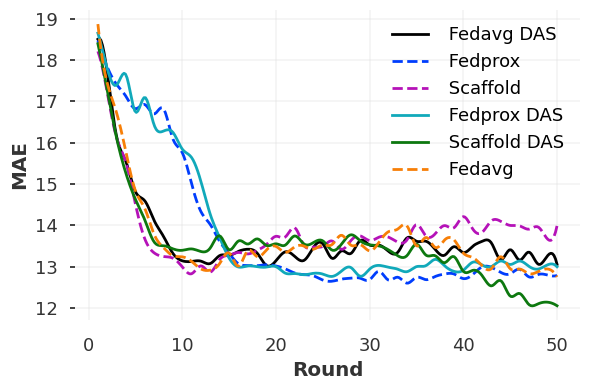

In [7]:
from scipy.interpolate import make_interp_spline
def plot_convergence_from_metrics2(building_id, model_strategies, metric_name,
                                   metrics_dir, save_path=None, show_plot=True,
                                   smooth=True):
    metrics_dir = Path(metrics_dir)
    save_path = Path(save_path) if save_path else None

    if save_path:
        save_path.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(6, 4))

    for model_strategy in model_strategies:
        file_name = f"cid{building_id}_{model_strategy}_metrics.csv"
        file_path = metrics_dir / file_name

        if not file_path.exists():
            print(f"❌ Missing metrics file: {file_path}")
            continue

        df = pd.read_csv(file_path)
        if metric_name not in df.columns:
            print(f"⚠️ '{metric_name}' not found in {file_name}")
            continue

        x = df["round"].values
        y = df[metric_name].values
        label = clean_label(model_strategy)

        label = label.replace('Gru', "").replace("Diff", "DAS")
        label = label.replace('Lstm', "")

        if smooth and len(x) > 3:
            # Fit spline for smoother curve
            x_new = np.linspace(x.min(), x.max(), 300)
            spline = make_interp_spline(x, y, k=3)
            y_smooth = spline(x_new)
            
            if 'DAS' in label:
                plt.plot(x_new, y_smooth, label=label, lw=2)
            else:
                plt.plot(x_new, y_smooth, label=label, lw=2, linestyle='--')


        else:
            plt.plot(x, y, marker='o', markersize=4, label=label)

    #plt.title(f"Convergence on Building {building_id} ({metric_name})", fontsize=14)
    plt.xlabel("Round")
    plt.ylabel(metric_name)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Get the current Axes object
    ax = plt.gca()

    # Set the border color and linewidth for all spines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # Set border color
        spine.set_linewidth(2)       # Set border thickness
    

    if save_path:
        metric_clean = metric_name.replace(" ", "").replace("(", "").replace(")", "").replace("%", "pct")
        out_file = save_path / f"{building_id}_{metric_clean}.png"
        plt.savefig(out_file, dpi=300, bbox_inches="tight")
        print(f"✅ Saved plot to: {out_file}")

    if show_plot:
        plt.show()
    else:
        plt.close()


plot_convergence_from_metrics2(
    building_id=128,
    model_strategies=["gru_fedAvg_diff0", "gru_fedProx", "gru_scaffold_lr", "gru_fedProx_diff","gru_scaffold_diff","gru_fedAvg" ],
    metric_name="MAE",
    metrics_dir="metrics-plots",
    save_path="plots/gru/",  # <== folder only!
    smooth=True
)


✅ Saved plot to: plots/lstm/128_MAE.png


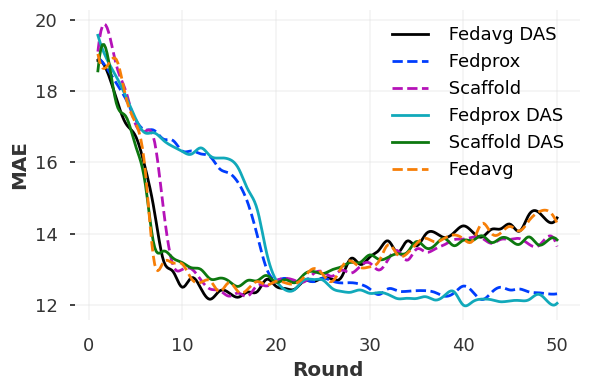

In [8]:
plot_convergence_from_metrics2(
    building_id=128,
    model_strategies=["lstm_fedAvg_diff0", "lstm_fedProx", "lstm_scaffold_lr", "lstm_fedProx_diff","lstm_scaffold_diff","lstm_fedAvg" ],
    metric_name="MAE",
    metrics_dir="metrics-plots",
    save_path="plots/lstm/",  # <== folder only!
    smooth=True
)
